
# CIFAR10 - Deep Learning Workshop
This notebook was created by Eden Levy & Elior Nehemya.


---
In this assignment we will:

1.   Explore the CIFAR10 dataset. 
2.   Build our first CNN model and finetune it.
3.   We will use transfer learning with several adaptations, and feature extraction for traditional ML algorithms.

Each section is highly detailed in our report for further understanding.










# 1. Exploration  over CIFAR10
Deeper insight can be found in https://www.cs.toronto.edu/~kriz/cifar.html

First we will import relevent libraries and load CIFAR10 

In [1]:
from keras.datasets import cifar10
from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D,MaxPool2D,Dropout,BatchNormalization,GlobalAveragePooling2D
from keras.utils import to_categorical
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


170500096/170498071 [==============================] - 13s 0us/step


Get some knowledge of the  dataset

Dataset size is: 50000 train and 10000 test examples, total 60000 examples.
The dimensions of an example is: (32, 32, 3)
Class distribution:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


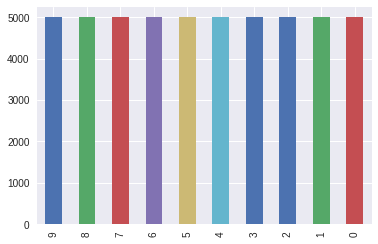

In [0]:
#Exploratory data analysis
print('Dataset size is: {} train and {} test examples, total {} examples.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[0] + x_test.shape[0]))
print('The dimensions of an example is: {}'.format(x_train[0].shape))
print('Class distribution:')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
y_train_df = pd.DataFrame(data = y_train, columns = ['Class'])
y_train_df.iloc[:,-1].value_counts().plot(kind = 'bar') #data is evenly distributed

The next function can print several images to the user

In [0]:
def plot_multiple_imgs(X,y,nrow=2,ncol=2,figsize=(13,7),preds=None,skip=0):
    fig,ax = plt.subplots(nrows=nrow,ncols=ncol,figsize=figsize)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(nrow*ncol):
        ax[i//ncol,i%ncol].imshow(X[skip+i],cmap='binary')
        ax[i//ncol,i%ncol].set_xticks([])
        ax[i//ncol,i%ncol].set_yticks([])
        if preds is not None:
            ax[i//ncol,i%ncol].text(0.85, 0.1, str(preds[skip+i]), transform=ax[i//ncol,i%ncol].transAxes,
                                   color='green' if y[skip+i]==preds[skip+i] else 'red',weight='bold')
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
        else:
            ax[i//ncol,i%ncol].text(0.05, 0.1, str(y[skip+i]), color='blue',transform=ax[i//ncol,i%ncol].transAxes,weight='bold')
    plt.show()

Now lets use it to view some of our images

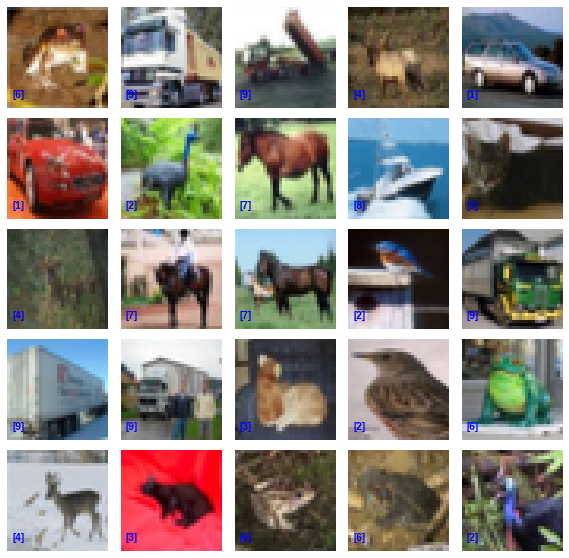

In [0]:
plot_multiple_imgs(x_train,y_train,5,5,(10,10))

# 2. Step by Step CNN
At this section we will build CNN model than we will try to upgrade it with different methods

Here we define some functions to plot and evaluate our models.

In [0]:
 
def plot_graphs(history):
  plt.subplot(2, 1 , 1)
  
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('validation accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
  plt.subplot(2, 1 , 2)
  
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('validation loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  
def plot_conf_matrix(model, x_test, y_test):
  preds = model.predict(x_test)
  preds_cat = np.argmax(preds, axis=1)
  sns.heatmap(confusion_matrix(y_test, preds_cat), cmap='Greens', annot=True, fmt='d')
  plt.xlabel('Prediction')
  plt.ylabel('True label')
  plt.title('Classification results on test set')
  return preds_cat
  
def plot_all(history, model, x_test, y_test):
  plot_graphs(history)
  preds_cat = plot_conf_matrix(model, x_test, y_test)
  
  acc_test = accuracy_score(y_test, preds_cat)*100
  acc_val = np.max(history.history['val_acc'])*100
  acc_train = np.max(history.history['acc'])*100
  
  dec = 3
  
  print('Model accuracy on test set is {}%'.format(np.around(acc_test, decimals=dec)))
  print('Model accuracy on validation set is {}%'.format(np.around(acc_val, decimals=dec)))
  print('Model accuracy on train set is {}%'.format(np.around(acc_train, decimals=dec)))

This is our first CNN model.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 128)         73856     
__________

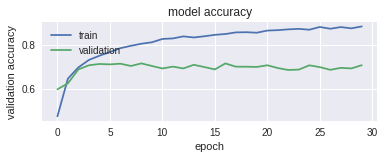

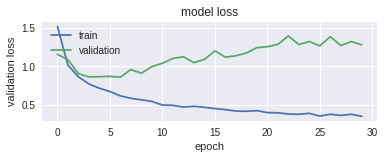

ValueError: ignored

In [0]:
def build_CNN_1():  
  model = Sequential()
  
  model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
  model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
  model.add(MaxPool2D())
  
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
  model.add(MaxPool2D())
  
  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
  model.add(MaxPool2D())
  
  model.add(Flatten())
  model.add(Dense(10,activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  
  return model


model1=build_CNN_1()
model1.summary()
history1 = model1.fit(x_train,to_categorical(y_train),validation_split=0.2,shuffle=True,epochs=30)


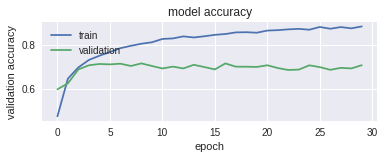

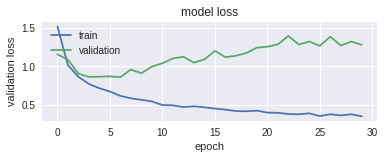

Model accuracy on test set is 69.72%
Model accuracy on validation set is 71.6%
Model accuracy on train set is 88.518%


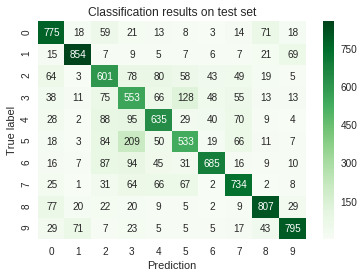

In [0]:
plot_all(history1, model1, x_test,y_test)

Now we will try 2 out of three methods to finetune our model.

---
First, we will try adding data augmantation to handle the overfiting.

In [0]:
#spliting the data for the augmentation
x_train_aug, x_val_aug, y_train_aug, y_val_aug = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 128)         73856     
__________

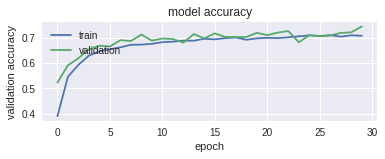

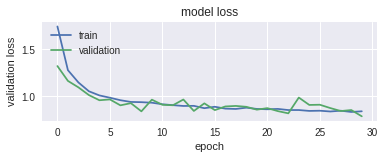

Model accuracy on test set is 73.67%
Model accuracy on validation set is 74.51%
Model accuracy on train set is 71.055%


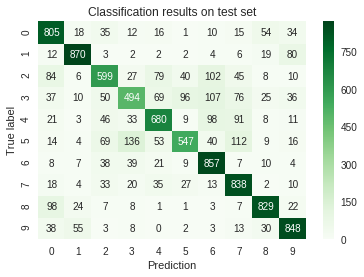

In [0]:
# upgrade 1  aug 

dataAug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
dataAug.fit(x_train_aug)

def build_model2():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D())

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D())

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

  
model2 = build_model2()  
model2.summary()
history2 = model2.fit_generator(dataAug.flow(x_train_aug, to_categorical(y_train_aug), batch_size=32,shuffle = True),
                    steps_per_epoch=len(x_train_aug) / 32, epochs=30, validation_data = (x_val_aug, to_categorical(y_val_aug) ))
plot_all(history2, model2, x_test,y_test)

Upgrade number two, here we add batch normalization layers:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)       

KeyError: ignored

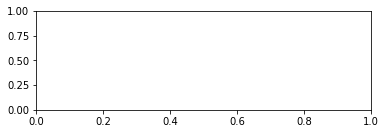

In [5]:
# upgrade 2  aug + batch normalization
dataAug = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    )
dataAug.fit(x_train_aug)

def build_model3():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(32,32,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

model3 = build_model3()
history3 = model3.fit_generator(dataAug.flow(x_train_aug, to_categorical(y_train_aug), batch_size=32,shuffle = True),
                    steps_per_epoch=len(x_train_aug) / 32, epochs=30, validation_data = ( x_val_aug, to_categorical(y_val_aug) ))
plot_all(history3, model3, x_test,y_test)